<a href="https://colab.research.google.com/github/phamthien300820/CS114.K21/blob/master/CS114_K21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Nạp thư viện
import tensorflow as tf
import random as rn
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
import keras.preprocessing.image as img
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from keras.applications.resnet50 import ResNet50
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline  
style.use('ggplot')
sns.set(style='whitegrid',color_codes=True)

#Những công cụ sử dụng
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator

# Thư viện deeplearning
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import InputLayer
 


Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
os.listdir('/content/drive/My Drive/Machine_Learning Helmet')

['Không có xe máy', 'Có người đi xe máy']

In [4]:
#resize ảnh 256x256(IMG_SIZE), chuyển đổi hình ảnh thành mảng
def convert2array(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
        except:
            pass
        
def assign_label(img,label):
    return label

In [5]:
X=[]
Z=[]
IMG_SIZE=256
have="/content/drive/My Drive/Machine_Learning Helmet/Có người đi xe máy"
not_have="/content/drive/My Drive/Machine_Learning Helmet/Không có xe máy"
#gán label cho dữ liệu
convert2array('have',have)
convert2array('not_have',not_have)

100%|██████████| 987/987 [17:05<00:00,  1.04s/it]


In [ ]:
X


In [6]:
np.save("/content/drive/My Drive/X.npy",X)

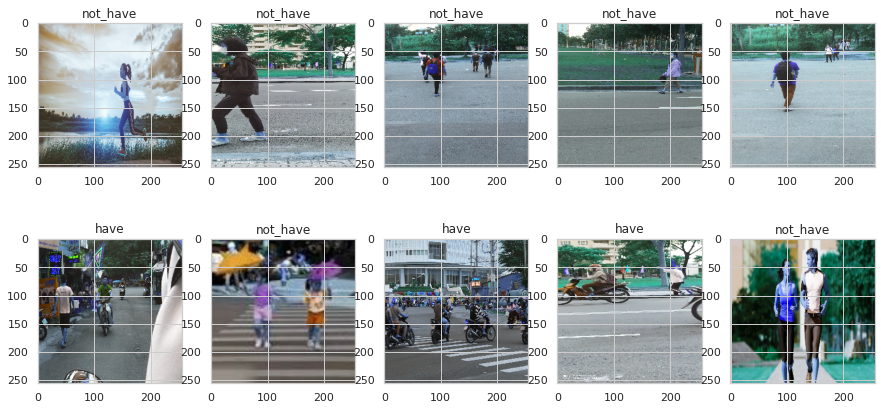

In [7]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(15,15)
#hiển thị một số hình ảnh
for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:])
        ax[i,j].set_title(Z[l])
        ax[i,j].set_aspect('equal')

In [8]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)# biến đổi nhãn thành 0 và 1
print(Y)
X=np.load("/content/drive/My Drive/X.npy")
X=np.array(X)
#rate 75:25
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=1337)


[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [9]:
Res_model=ResNet50(include_top=False, weights='imagenet',input_shape=(256,256,3), pooling='max')
'''include_top=False : load a network that doesn't include the classification layers at the top,
 which is ideal for feature extraction
'''
Res_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94658560/94653016 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 

In [10]:
model=Sequential()
model.add(Res_model)
model.add(Dropout(0.20))
model.add(Dense(2048,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [11]:
epochs=50
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)
Res_model.trainable=False 
  
model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1026      
Total params: 30,408,066
Trainable params: 6,820,354
Non-trainable params: 23,587,712
__________________________________

In [12]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test,y_test))

Train on 1578 samples, validate on 526 samples
Epoch 1/50
1578/1578 [==============================] - 21s 14ms/step - loss: 0.8891 - accuracy: 0.7155 - val_loss: 0.3791 - val_accuracy: 0.8441
Epoch 2/50
1578/1578 [==============================] - 13s 8ms/step - loss: 0.2918 - accuracy: 0.8834 - val_loss: 0.2787 - val_accuracy: 0.8840
Epoch 3/50
1578/1578 [==============================] - 13s 8ms/step - loss: 0.2556 - accuracy: 0.9163 - val_loss: 0.1763 - val_accuracy: 0.9163
Epoch 4/50
1578/1578 [==============================] - 13s 8ms/step - loss: 0.1811 - accuracy: 0.9436 - val_loss: 0.3171 - val_accuracy: 0.8764
Epoch 5/50
1578/1578 [==============================] - 13s 9ms/step - loss: 0.1599 - accuracy: 0.9430 - val_loss: 0.2379 - val_accuracy: 0.8973
Epoch 6/50
1578/1578 [==============================] - 13s 9ms/step - loss: 0.1206 - accuracy: 0.9582 - val_loss: 0.2780 - val_accuracy: 0.8878
Epoch 7/50
1578/1578 [==============================] - 14s 9ms/step - loss: 0.135

In [ ]:
model.save('model.model')

In [22]:
TRAINING_PLOT_PATH = os.path.sep.join(["training_plot_loss_resnet50.png"])

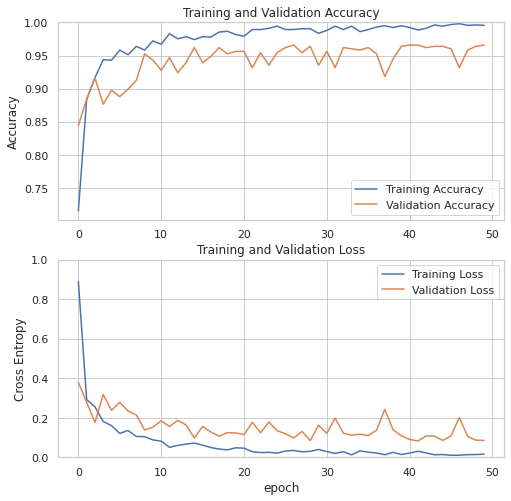

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/My Dataset/Res_model.h5')

In [ ]:
import random
path = "/content/drive/My Drive/Train/Có người đi xe máy"
files = os.listdir(path)
random.shuffle(files)

  0%|          | 0/12 [00:00<?, ?it/s]

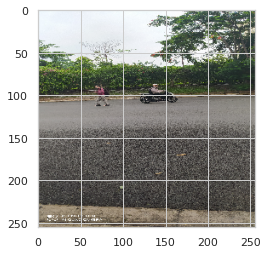

  8%|▊         | 1/12 [00:00<00:05,  1.98it/s]

Co xe may 


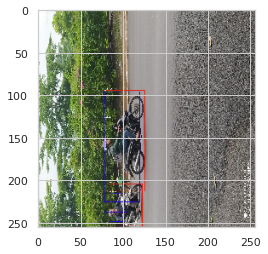

 17%|█▋        | 2/12 [00:00<00:04,  2.12it/s]

Co xe may 


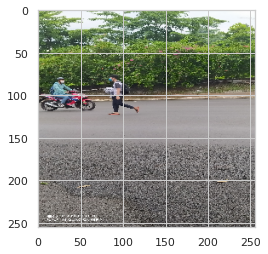

 25%|██▌       | 3/12 [00:01<00:04,  2.12it/s]

Co xe may 


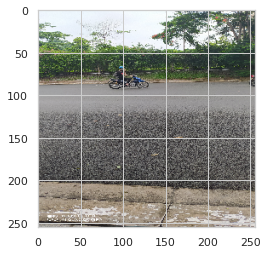

 33%|███▎      | 4/12 [00:01<00:03,  2.06it/s]

Co xe may 


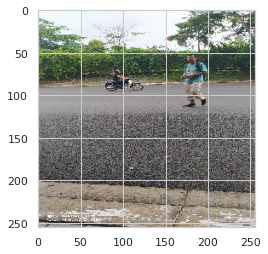

 42%|████▏     | 5/12 [00:02<00:03,  2.03it/s]

Co xe may 


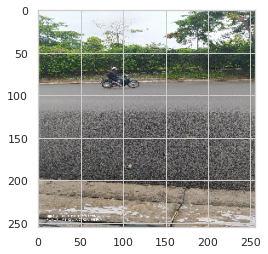

 50%|█████     | 6/12 [00:03<00:03,  1.80it/s]

Co xe may 


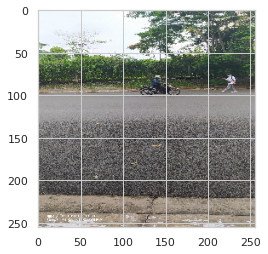

 58%|█████▊    | 7/12 [00:03<00:02,  1.85it/s]

Co xe may 


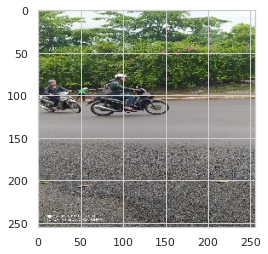

 67%|██████▋   | 8/12 [00:04<00:02,  1.93it/s]

Co xe may 


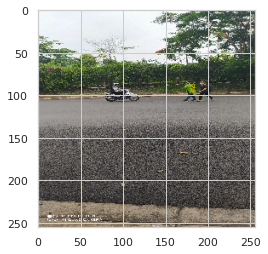

 75%|███████▌  | 9/12 [00:04<00:01,  1.96it/s]

Co xe may 


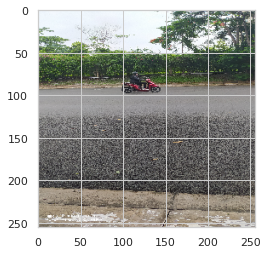

 83%|████████▎ | 10/12 [00:05<00:01,  1.97it/s]

Co xe may 


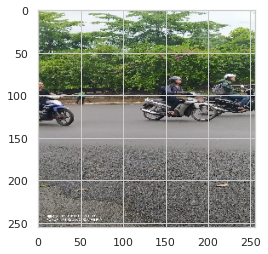

 92%|█████████▏| 11/12 [00:05<00:00,  2.03it/s]

Co xe may 


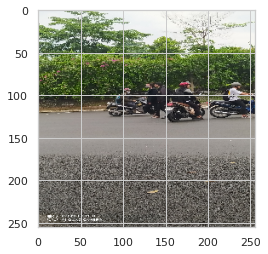

100%|██████████| 12/12 [00:05<00:00,  2.00it/s]

Co xe may 


In [ ]:
for i in tqdm(files):
    pth = os.path.join(path,i)
    X = cv2.imread(pth,cv2.IMREAD_COLOR)
    X = cv2.resize(X,(256,256))
    plt.figure()
    plt.imshow(X[:,:,::-1]) 
    plt.show()  

    X = np.array(X)
    X = np.expand_dims(X, axis=0)

    y_pred = np.round(model.predict(X))
    if y_pred[0][0] == 1:
        print("Co xe may ")
    else:
        print("Khong co xe may")

In [34]:
y_predict=model.predict(x_test)
y_predict=np.argmax(y_predict, axis=1)
y_true=np.argmax(y_test, axis=1)

In [35]:
y_predict.shape,y_true.shape

((526,), (526,))

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_predict, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       287
           1       0.98      0.97      0.98       239

    accuracy                           0.98       526
   macro avg       0.98      0.98      0.98       526
weighted avg       0.98      0.98      0.98       526



**Fine Tune**

In [25]:
Res_model.trainable = True

In [26]:
#Xem có bao nhiêu lớp trong Res model
print("Num of layers in the Res model: ", len(Res_model.layers))

# Fine tune từ lớp này trở đi
fine_tune_at = 100

# Freeze tất cả các lớp trước lớp `fine_tune_at` 
for layer in Res_model.layers[:fine_tune_at]:
  layer.trainable =  False

Num of layers in the Res model:  176


In [27]:
model_ft=Sequential()
model_ft.add(Res_model)
model_ft.add(Dropout(0.20))
model_ft.add(Dense(2048,activation='relu'))
model_ft.add(Dense(1024,activation='relu'))
model_ft.add(Dense(512,activation='relu'))
model_ft.add(Dense(2,activation='softmax'))

In [28]:
base_learning_rate = 0.0001
model_ft.compile(optimizer=Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
model_ft.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 1026      
Total params: 30,408,066
Trainable params: 26,273,282
Non-trainable params: 4,134,784
__________________________________

In [30]:
fine_tune_epochs = 10
initial_epochs =10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model_ft.fit(x_train,y_train,
                         epochs=total_epochs,
                         validation_data=(x_test,y_test))

Train on 1578 samples, validate on 526 samples
Epoch 1/20
1578/1578 [==============================] - 20s 13ms/step - loss: 0.8648 - accuracy: 0.7655 - val_loss: 0.3385 - val_accuracy: 0.8935
Epoch 2/20
1578/1578 [==============================] - 19s 12ms/step - loss: 0.1904 - accuracy: 0.9347 - val_loss: 0.3378 - val_accuracy: 0.9030
Epoch 3/20
1578/1578 [==============================] - 19s 12ms/step - loss: 0.0902 - accuracy: 0.9664 - val_loss: 0.1937 - val_accuracy: 0.9354
Epoch 4/20
1578/1578 [==============================] - 19s 12ms/step - loss: 0.0806 - accuracy: 0.9702 - val_loss: 0.1996 - val_accuracy: 0.9392
Epoch 5/20
1578/1578 [==============================] - 19s 12ms/step - loss: 0.0407 - accuracy: 0.9854 - val_loss: 0.1599 - val_accuracy: 0.9430
Epoch 6/20
1578/1578 [==============================] - 20s 12ms/step - loss: 0.0302 - accuracy: 0.9892 - val_loss: 0.1899 - val_accuracy: 0.9354
Epoch 7/20
1578/1578 [==============================] - 20s 12ms/step - loss:

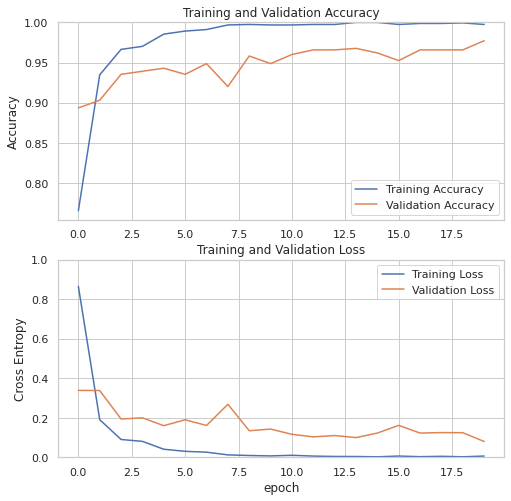

In [31]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
y_predict=model_ft.predict(x_test)
y_predict=np.argmax(y_predict, axis=1)
y_true=np.argmax(y_test, axis=1)

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_predict, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       287
           1       0.97      0.98      0.98       239

    accuracy                           0.98       526
   macro avg       0.98      0.98      0.98       526
weighted avg       0.98      0.98      0.98       526



In [ ]:
model_ft.save('/content/model_ft.pkl')

NameError: ignored

In [ ]:
import pickle

In [ ]:
classifier_file = "model1.pkl"
with open(classifier_file, 'wb') as outfile:
                pickle.dump((model, (0, 1)), outfile)

NotImplementedError: ignored